In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveDrift, ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.utils.statistics import plot_residuals_analysis
from darts.metrics import mape

c:\Users\Ayden\venvs\ml39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MODELS = {}

def quick_plot(ts_all, label):
    ts_all.drop_before(pd.Timestamp('2022-01-01')).plot(label='acutal')
    MODELS[label][1].plot(label=label)

def get_results(test):
    return pd.DataFrame([{'model': m, 'mape': mape(test, MODELS[m][1])} for m in MODELS]).sort_values('mape').reset_index(drop=True)

def quick_train_and_fc(model, label, train, test):
    model.fit(train)
    forecast = model.predict(len(test))
    MODELS[label] = [model, forecast]

### Data Import

In [8]:
cutoff = '2023-01-01'
start_date = '2016-08-31'

In [6]:
df_all = pd.read_csv('../data.csv', index_col=0)

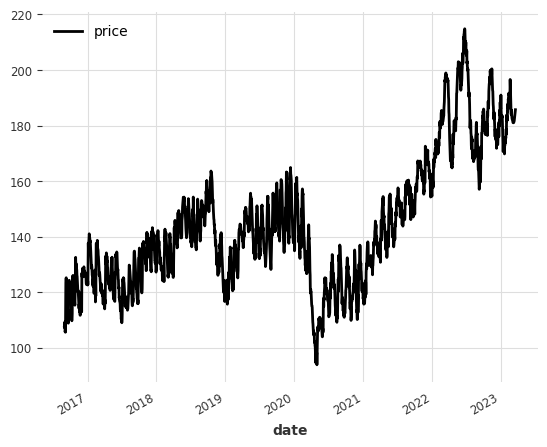

In [9]:
ts_all = TimeSeries.from_dataframe(df_all.reset_index(drop=True), time_col='date').drop_before(pd.Timestamp(start_date))
ts_all.plot()

In [10]:
train, test = ts_all.split_before(pd.Timestamp(cutoff))

### Naive Models

In [11]:
MODELS = {}

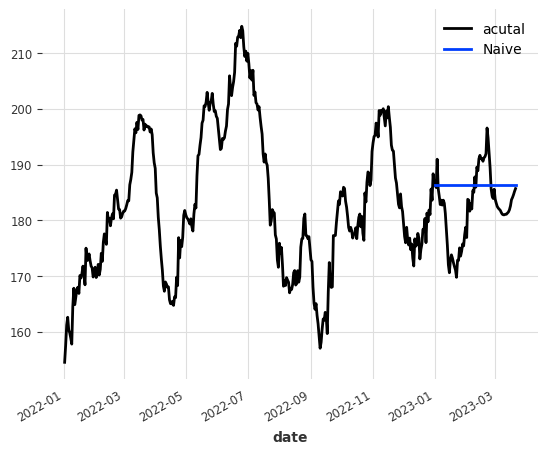

In [13]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(test))

MODELS['Naive'] = [naive_model, naive_forecast]

quick_plot(ts_all, 'Naive')

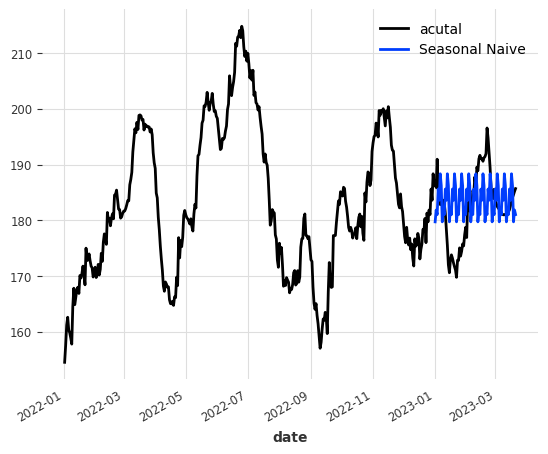

In [14]:
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(test))

MODELS['Seasonal Naive'] = [seasonal_model, seasonal_forecast]

quick_plot(ts_all, 'Seasonal Naive')

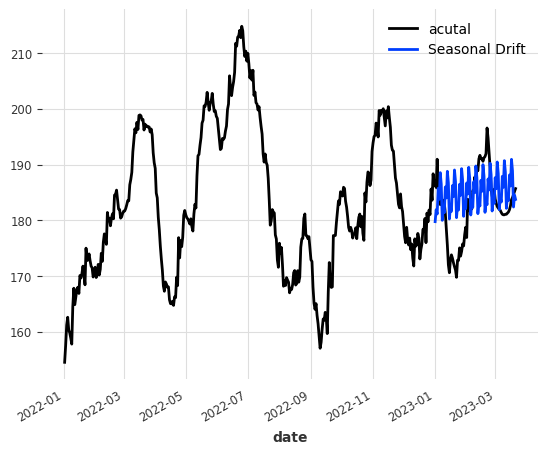

In [15]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(test))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

MODELS['Seasonal Drift'] = [None, combined_forecast]

quick_plot(ts_all, 'Seasonal Drift')


### Simple Models

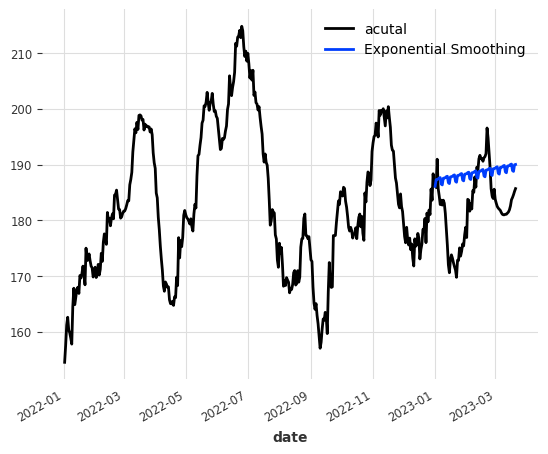

In [17]:
quick_train_and_fc(ExponentialSmoothing(), 'Exponential Smoothing', train, test)
quick_plot(ts_all, 'Exponential Smoothing')

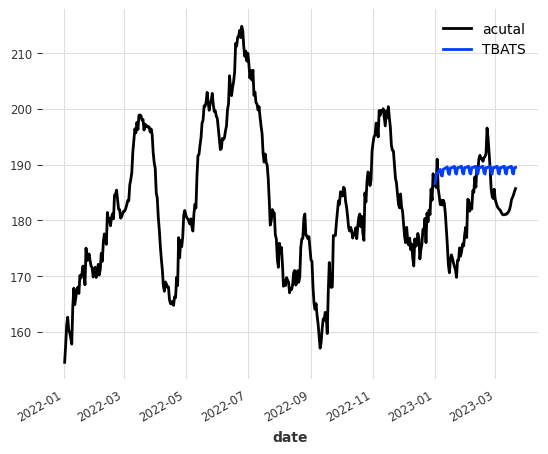

In [19]:
quick_train_and_fc(TBATS(), 'TBATS', train, test)
quick_plot(ts_all, 'TBATS')

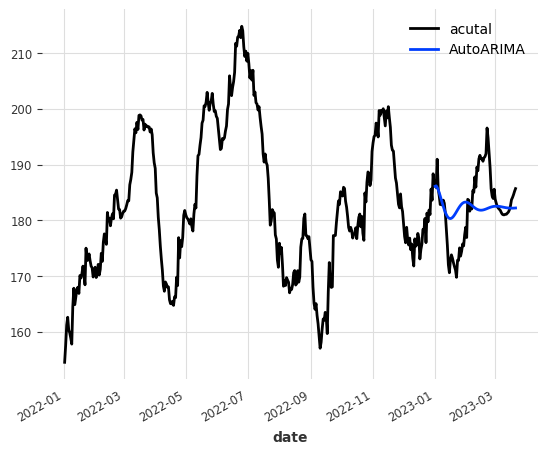

In [20]:
quick_train_and_fc(AutoARIMA(), 'AutoARIMA', train, test)
quick_plot(ts_all, 'AutoARIMA')

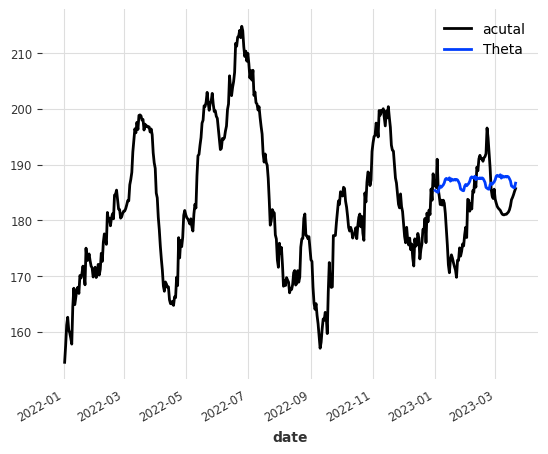

In [22]:
quick_train_and_fc(Theta(), 'Theta', train, test)
quick_plot(ts_all, 'Theta')

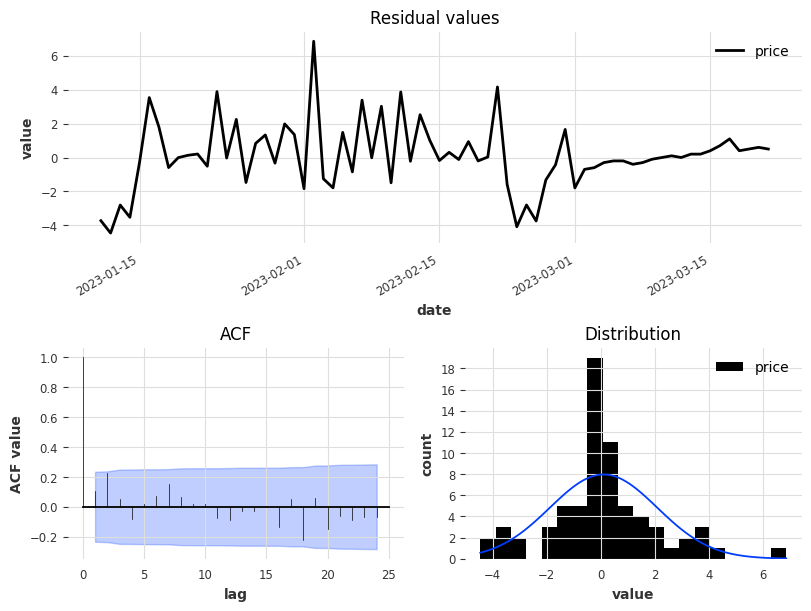

In [29]:
plot_residuals_analysis(MODELS['AutoARIMA'][0].residuals(test))

In [24]:
get_results(test)

,model,mape
0,AutoARIMA,2.477594
1,Seasonal Naive,3.129548
2,Naive,3.249749
3,Seasonal Drift,3.265358
4,Theta,3.509929
5,Exponential Smoothing,3.942588
6,TBATS,4.230220


### Modelling Approach
- CV Approach
    - Train a model that becomes very good at producing 1-week and 2-week probabilistic forecasts
- Introduce past covariates
- Potentially forecast the 1 week and 2 week figure as opposed to the days between

## CV Approach

- RandomForest
- LightGBM
- XGBModel
- ARIMA

In [29]:
nsw_df = pd.read_csv('../data.csv', index_col=0, parse_dates=['date'])
as_df = pd.read_csv('../aud_sgd_raw.csv', parse_dates=['date'], dayfirst=True)
co_df = pd.read_csv('../co_raw.csv', parse_dates=['date'])

j1 = pd.merge(
    left = nsw_df,
    right = co_df,
    how = 'left',
    left_on = 'date',
    right_on = 'date'
)

df_all = pd.merge(
    left = j1,
    right = as_df,
    how = 'left',
    left_on = 'date',
    right_on = 'date'
)

df_all.set_index('date', inplace=True)
df_all = df_all.interpolate(method='time').reset_index()
df_all

,date,price,crude_oil_price,aud_sgd
0,2016-08-01,110.821410,40.05,1.011500
1,2016-08-02,109.621591,39.50,1.019100
2,2016-08-03,108.222038,40.80,1.017900
3,2016-08-04,106.463961,41.92,1.023600
4,2016-08-05,105.745287,41.83,1.026300
...,...,...,...,...
2420,2023-03-18,184.100000,74.68,0.897333
2421,2023-03-19,184.600000,74.68,0.897767
2422,2023-03-20,185.200000,74.68,0.898200
2423,2023-03-21,185.700000,74.68,0.890600


In [34]:
ts_fuel = TimeSeries.from_dataframe(df_all, time_col='date', value_cols=['price'])
ts_co = TimeSeries.from_dataframe(df_all, time_col='date', value_cols=['crude_oil_price'])
ts_as = TimeSeries.from_dataframe(df_all, time_col='date', value_cols=['aud_sgd'])

In [11]:
from darts.dataprocessing.transformers import Scaler

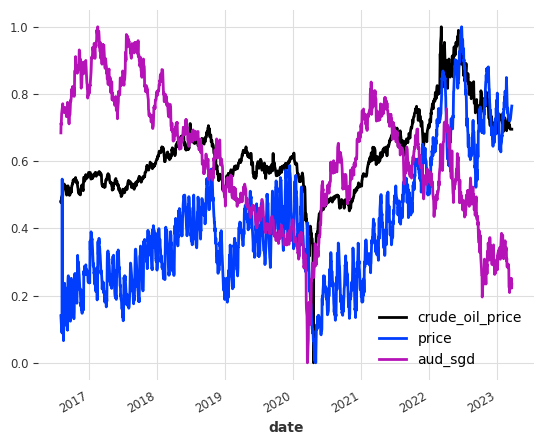

In [46]:
scaler_fuel, scaler_co, scaler_as = Scaler(), Scaler(), Scaler()

ts_co_s = scaler_co.fit_transform(ts_co)
ts_fuel_s = scaler_fuel.fit_transform(ts_fuel)
ts_as_s = scaler_as.fit_transform(ts_as)

ts_co_s.plot()
ts_fuel_s.plot()
ts_as_s.plot()

In [66]:
from darts.models.forecasting.lgbm import LightGBMModel
lgbm = LightGBMModel(
    lags=200, likelihood='quantile'
)

lgbm.fit(
    series=ts_fuel
)

In [89]:
import numpy as np

def eval_hfc(model, covariates = None):
    hfc = model.historical_forecasts(
        series=ts_fuel,
        past_covariates=covariates,
        start = 0.75,
        forecast_horizon=15,
        stride = 18,
        retrain = False,
        last_points_only = False
    )
    mmape = np.mean([mape(ts_fuel, fc) for fc in hfc])

    return hfc, mmape

def plot_hfc(hfc, n):
    for fc in hfc[-n:]:
        fc.plot()
    ts_fuel[-365:].plot()

In [87]:
lg2 = LightGBMModel(lags=50, lags_past_covariates=20, likelihood='quantile')

3.984771026609817


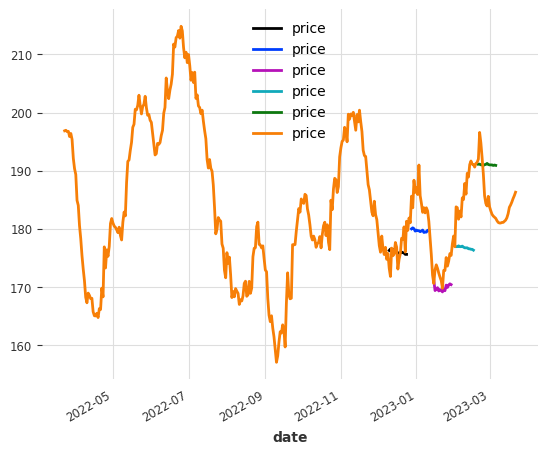

In [88]:
h, m = eval_hfc(lg2, [ts_co_s])
plot_hfc(h, 5)
print(m)

3.99994690239546


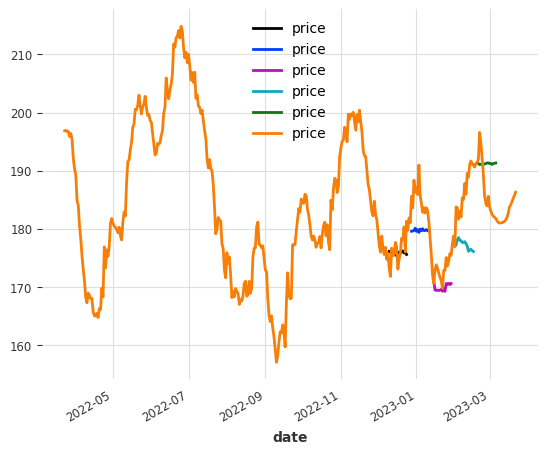

In [90]:
h, m = eval_hfc(lg2, [ts_co])
plot_hfc(h, 5)
print(m)

4.329677803766737


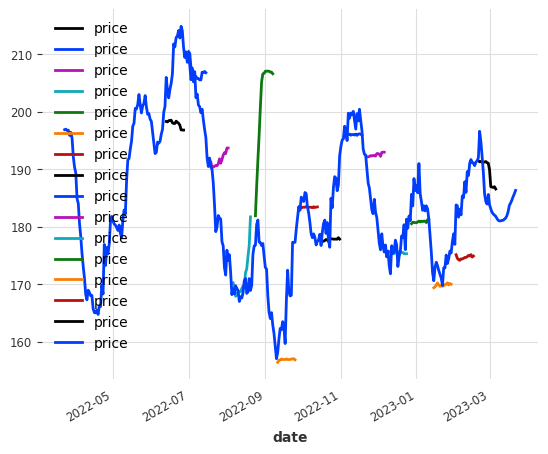

In [96]:
# lg2 = LightGBMModel(lags=200, lags_past_covariates=50, likelihood='quantile')
# h, m = eval_hfc(lg2, [ts_co_s, ts_as_s])
plot_hfc(h, 15)
print(m)

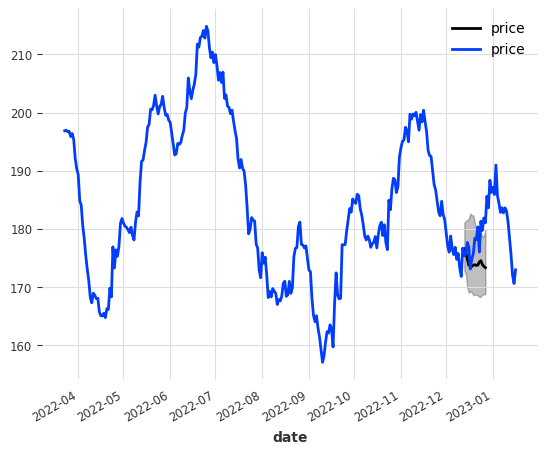

In [116]:
# lg2.fit(series=ts_fuel[:-100], past_covariates=[ts_co_s, ts_as_s])
pred = lg2.predict(n=15, num_samples=1000)
pred.plot()
ts_fuel[-365:-365+300].plot()

4.210385380527937


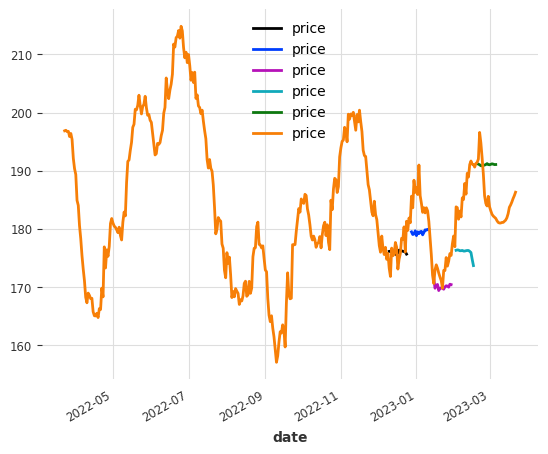

In [93]:
lg = LightGBMModel(lags=50, likelihood='quantile')
h, m = eval_hfc(lg, None)
plot_hfc(h, 5)
print(m)

In [83]:
np.mean([mape(ts_fuel, fc) for fc in hfc])

3.518896576909521

In [69]:
pred = lgbm.predict(15, num_samples=10000)

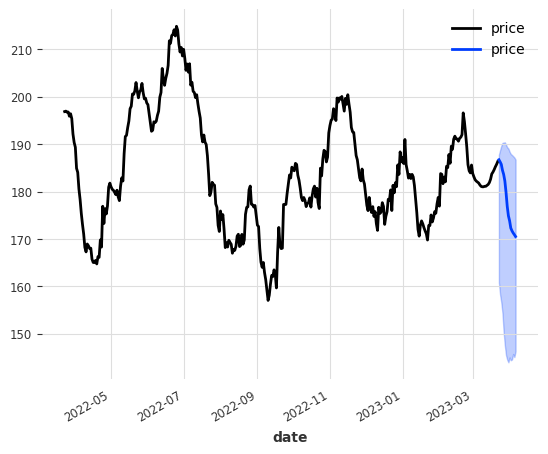

In [70]:
ts_fuel[-365:].plot()
pred.plot()

In [36]:
hfc = MODELS['AutoARIMA'][0].historical_forecasts(test, forecast_horizon=7, stride=7, start=pd.Timestamp('2023-01-15'), last_points_only=False)

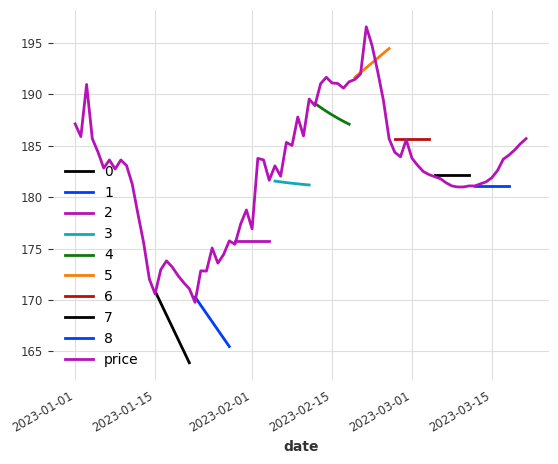

In [45]:
for i, f in enumerate(hfc):
    f.plot(label=str(i))
test.plot()